In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


print(x_train.shape)


[7 2 1 ... 4 5 6]
(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
from keras.layers import LSTM

input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
n_feature = 1
epochs = 30

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = LSTM(latent_dim)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


models = (encoder, decoder)
# data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = n_feature*mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size*image_size 
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dense_5 (D

In [6]:

vae.fit(x_train,
        epochs=10,
        batch_size=batch_size)
#vae.save_weights('vae_cnn_mnist.h5')





Epoch 1/10





60000/60000 [==============================] - 106s 2ms/step - loss: 52.4450
Epoch 2/10
60000/60000 [==============================] - 106s 2ms/step - loss: 44.6959
Epoch 3/10
60000/60000 [==============================] - 112s 2ms/step - loss: 42.6615
Epoch 4/10
60000/60000 [==============================] - 105s 2ms/step - loss: 41.5414
Epoch 5/10
60000/60000 [==============================] - 105s 2ms/step - loss: 40.8016
Epoch 6/10
60000/60000 [==============================] - 112s 2ms/step - loss: 40.2468
Epoch 7/10
60000/60000 [==============================] - 105s 2ms/step - loss: 39.8204
Epoch 8/10
60000/60000 [==============================] - 105s 2ms/step - loss: 39.4939
Epoch 9/10
60000/60000 [==============================] - 104s 2ms/step - loss: 39.1996
Epoch 10/10
60000/60000 [==============================] - 105s 2ms/step - loss: 38.9540


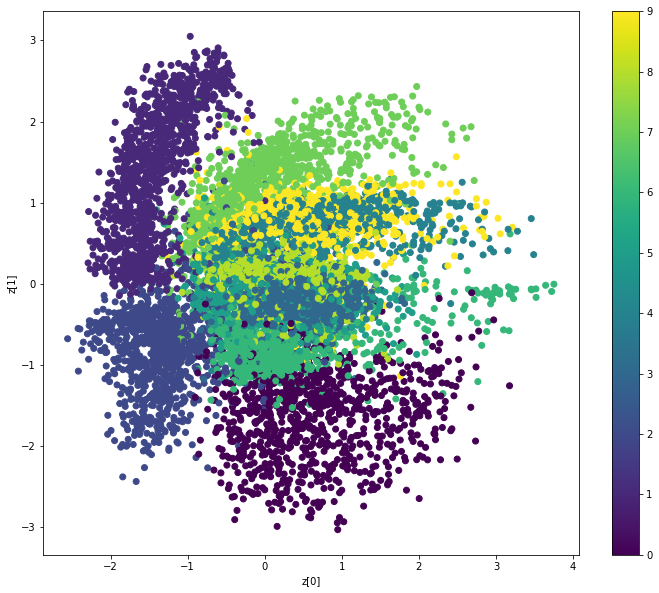

In [8]:

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
   

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    # filename = os.path.join(model_name, "digits_over_latent.png")
    # # display a 30x30 2D manifold of digits
    # n = 30
    # digit_size = 28
    # figure = np.zeros((digit_size * n, digit_size * n))
    # # linearly spaced coordinates corresponding to the 2D plot
    # # of digit classes in the latent space
    # grid_x = np.linspace(-4, 4, n)
    # grid_y = np.linspace(-4, 4, n)[::-1]
    # 
    # for i, yi in enumerate(grid_y):
    #     for j, xi in enumerate(grid_x):
    #         z_sample = np.array([[xi, yi]])
    #         x_decoded = decoder.predict(z_sample)
    #         digit = x_decoded[0].reshape(digit_size, digit_size)
    #         figure[i * digit_size: (i + 1) * digit_size,
    #                j * digit_size: (j + 1) * digit_size] = digit
    # 
    # plt.figure(figsize=(10, 10))
    # start_range = digit_size // 2
    # end_range = n * digit_size + start_range + 1
    # pixel_range = np.arange(start_range, end_range, digit_size)
    # sample_range_x = np.round(grid_x, 1)
    # sample_range_y = np.round(grid_y, 1)
    # plt.xticks(pixel_range, sample_range_x)
    # plt.yticks(pixel_range, sample_range_y)
    # plt.xlabel("z[0]")
    # plt.ylabel("z[1]")
    # plt.imshow(figure, cmap='Greys_r')
    # plt.savefig(filename)
    # plt.show()
    
data = (x_test, y_test)    
plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")


(10000, 2) (10000, 2) (10000, 2)
Component 1 shape (10000, 2)
PCA variance ratio [0.5471812  0.45281878]


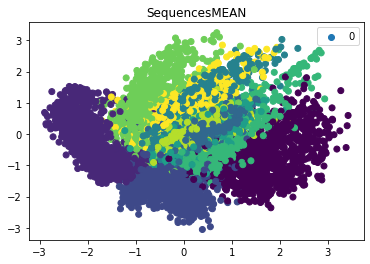

Component 1 shape (10000, 2)
PCA variance ratio [0.84528047 0.15471953]


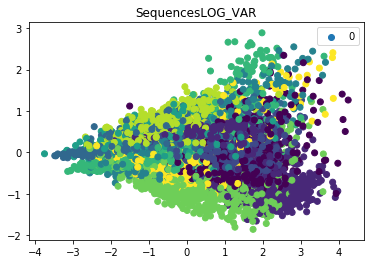

Component 1 shape (10000, 2)
PCA variance ratio [0.5451014 0.4548986]


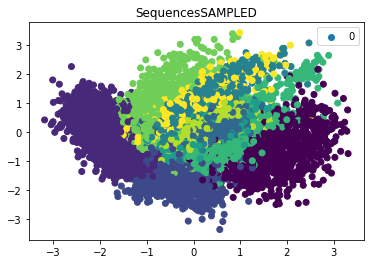

In [20]:
from sklearn.decomposition import PCA

enc_mean, enc_var, z_enc = encoder.predict(x_test,
                                   batch_size=batch_size)
# encodings = encoder.predict(train_matrix)
# enc_mean, enc_var, z_enc = encodings[0], encodings[1], encodings[2]
print(enc_mean.shape, enc_var.shape, z_enc.shape)

from mpl_toolkits.mplot3d import Axes3D  
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import norm


def plot_pca(title, i): 
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     markers = ['o', 'o', 'o', 'o', '^', '^', '^', '^', '^', '^']
#     ax.scatter(principalComponents[:, 0], 
#                 principalComponents[:, 1],  
#                 principalComponents[:, 2], marker=markers[index])

#     plt.legend(labels=np.arange(0, 9))
#     plt.title(str(title))
#     plt.show()
    plt.scatter(x=principalComponents[:, 0], 
                y=principalComponents[:, 1], c=y_test)

        #break
    
    plt.legend(labels=np.arange(0, 9))
    plt.title(str(title))
    plt.show()


enc_list = [enc_mean, enc_var, z_enc]
titles = ["MEAN","LOG_VAR","SAMPLED"]
for i,enc in enumerate(enc_list):
    scaler = StandardScaler()
    enc_input = scaler.fit_transform(enc) 
    pca = PCA(2)
    principalComponents = pca.fit_transform(enc_input)
    print("Component 1 shape", principalComponents.shape)
    print("PCA variance ratio", pca.explained_variance_ratio_) 
    plot_pca('Sequences'+titles[i], 0)
    # principalComponents = enc
    # plot_pca('Sequences_Not_Pca'+titles[i], 0)
